In [117]:
import torch
import pickle
from main_mlp import *
import torch.nn as nn
from matplotlib import pyplot as plt
plt.style.use("bmh")




In [118]:
def save_list(target_list, model_name, ext):
    filename = f"/shared/vsathia2/inference_outputs/{model_name}_{ext}"
    with open(filename, "wb") as fp:
        pickle.dump(target_list, fp)

In [119]:
def get_list(model_name, ext):
    target_list = []
    filename = f"/shared/vsathia2/inference_outputs/{model_name}_{ext}"
    with open(filename, "rb") as fp:
        target_list = pickle.load(fp)
    return target_list

In [4]:
import argparse
import torch
from transformers import AutoTokenizer, LlamaForCausalLM, AutoModelForCausalLM, LlamaTokenizer
import sys
from statistics import mean
import numpy as np
import torch
from datasets import load_dataset
from tqdm import tqdm
import re
from matplotlib import pyplot as plt
import torch.nn.functional as F

import pandas as pd

#keep track of current decoder layer
lid = 0
DATA_PATH = "/shared/vsathia2/sp_mlp_predictor/vanilla_llama/"
#keep track of start points(upto 50 layers)
fstarts = [0]*50
fmlp_ptrs = []
factv_ptrs = []
mlp_inputs = []
act_outputs = []
all_outputs = []
def actv_hook(module, inputs, outputs):
    # Need to save output of activation function
    global lid,fmlp_ptrs,factv_ptrs,fstarts,all_outputs
    act_outputs.append(outputs)
    #save this output for analysis later
    return outputs

def mlp_hook(module, inputs, outputs):
    # Need to save input of MLP
    global lid,fmlp_ptrs,factv_ptrs,fstarts
    mlp_inputs.append(inputs)
    lid+=1

    return outputs

def wikitext_detokenize(string):
    # contractions
    string = string.replace("s '", "s'")
    string = re.sub(r"/' [0-9]/", r"/'[0-9]/", string)
    # number separators
    string = string.replace(" @-@ ", "-")
    string = string.replace(" @,@ ", ",")
    string = string.replace(" @.@ ", ".")
    # punctuation
    string = string.replace(" : ", ": ")
    string = string.replace(" ; ", "; ")
    string = string.replace(" . ", ". ")
    string = string.replace(" ! ", "! ")
    string = string.replace(" ? ", "? ")
    string = string.replace(" , ", ", ")
    # double brackets
    string = re.sub(r"\(\s*([^\)]*?)\s*\)", r"(\1)", string)
    string = re.sub(r"\[\s*([^\]]*?)\s*\]", r"[\1]", string)
    string = re.sub(r"{\s*([^}]*?)\s*}", r"{\1}", string)
    string = re.sub(r"\"\s*([^\"]*?)\s*\"", r'"\1"', string)
    string = re.sub(r"'\s*([^']*?)\s*'", r"'\1'", string)
    # miscellaneous
    string = string.replace("= = = =", "====")
    string = string.replace("= = =", "===")
    string = string.replace("= =", "==")
    string = string.replace(" " + chr(176) + " ", chr(176))
    string = string.replace(" \n", "\n")
    string = string.replace("\n ", "\n")
    string = string.replace(" N ", " 1 ")
    string = string.replace(" 's", "'s")

    return string

def prepare_data(dpath="wikitext",dname="wikitext-2-raw-v1",split="test",text_column="text"):

    data_split = load_dataset(dpath, dname, split=split)
    text_list = "\n\n".join([wikitext_detokenize(t) for t in data_split[text_column]])
    return text_list

def evaluate(model,tokenizer,device="cuda:0",dataset_path="wikitext",dataset_name="wikitext-2-raw-v1",split="test",text_column="text",n_ctx=2048,seq_len=2048):

    # prepare data
    _text = prepare_data(dataset_path,dataset_name,split,text_column)
    tokens = tokenizer(_text, truncation=False, return_tensors="pt").input_ids.to(device)

    # process tokens to include batch size = (n_ctx / seq_len)

    cutoff = 393216

    # with tqdm(range(len(tokens[0]) // n_ctx), desc="Inference data collection: - ") as progress:
    for i in tqdm(range(0,min(cutoff,len(tokens[0])),n_ctx),desc="Inference loop"):
        print("Process tokens in batched manner")

        start = i
        end = start + n_ctx

        # vectorize inner loop
        tokens_batch = tokens[:,start:end].view(-1,seq_len)
        

        token_org = tokens_batch[0,0].item()
        tokens_batch[0,0] = tokenizer.bos_token_id

        global lid
        lid = 0
        device = 'cuda:0'

        with torch.no_grad():
            print(tokens_batch.shape)
            #model.to(device)
            #tokens_batch.to(device)
            outputs = model(tokens_batch)
        # print(f"output logit shape: {outputs.logits.shape}")

        tokens_batch[0,0] = token_org
        break

def generate_label(y):
    onehot = (y>0).to(y.dtype)
    return onehot

def main(args):
    # print(args)
    global DATA_PATH
    DATA_PATH = args.data_path
    # Init the tokenizer
    tokenizer=AutoTokenizer.from_pretrained(args.model_path,padding_side='left')
    tokenizer.eos_token=tokenizer.pad_token

    # Init the model itself
    # Use eager attention instead of flash/SDPA
    m = AutoModelForCausalLM.from_pretrained(args.model_path, device_map=args.device, attn_implementation="eager")

    n_layers = len(m.model.layers)

    #initialize file pointers
    global fmlp_ptrs, factv_ptrs
    
    with torch.no_grad():

        mlp_funcs = []
        mlp_handles = []
        actv_funcs = []
        actv_handles = []
        for i in range(n_layers):
            mlp_funcs.append(m.model.layers[i].mlp)
            actv_funcs.append(m.model.layers[i].mlp.act_fn)
            mlp_handles.append(mlp_funcs[-1].register_forward_hook(mlp_hook))
            actv_handles.append(actv_funcs[-1].register_forward_hook(actv_hook))
        
        #begin data collection
        evaluate(m,tokenizer)
        print("llm inference finished for ", args.model_name)
        
        #free all hooks
        for i in range(n_layers):
            mlp_handles[i].remove()
            actv_handles[i].remove()

        print("saving mlp inputs")
        save_list(mlp_inputs, args.model_name, "mlp_inputs")

        print("saving activation layer outputs")
        save_list(act_outputs, args.model_name, "act_outputs")
        
        #analyse all_outputs[32]
        #print("Analyzing sparsity predictor performance on ", args.model_name)
        #percentage_correct, percentage_missed = evaluate_sparsity_predictors(args, mlp_inputs, act_outputs)
        #visualize(percentage_correct, percentage_missed)
        
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='GCN')
    parser.add_argument("--dataset", type=str, default="wikitext",help="Dataset name")
    parser.add_argument("--model-path",type=str,default="/shared/vsathia2/hf_models/relu-llama-4bit-bnb-new/")
    parser.add_argument("--data-path",type=str,default="/shared/vsathia2/sp_mlp_predictor/relu-llama-4bit-bnb")
    parser.add_argument("--model_name",type=str,default="relu-llama-4bit-bnb-new")

    parser.add_argument("--device", type=str, default="cuda:0",
                        help="Select device to perform computations on")
    parser.add_argument(
        "--D",
        type=int,
        default=1000,
        help="low rank dimension",
    )
    #args = parser.parse_args()
    args = parser.parse_args(args=[])
    main(args)




You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Inference loop:   0%|                                                                           | 0/161 [00:00<?, ?it/s]

Process tokens in batched manner
torch.Size([1, 2048])


Inference loop:   0%|                                                                           | 0/161 [00:00<?, ?it/s]


llm inference finished for  relu-llama-4bit-bnb-new
saving mlp inputs
saving activation layer outputs


Evaluation

In [120]:
class Model(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        hidden_dim = 1000
        self.layers = torch.nn.Sequential(
        torch.nn.Linear(CONFIG[model_name]['d'], hidden_dim, bias=None),
        torch.nn.Linear(hidden_dim, CONFIG[model_name]['h'], bias=None),
        )
    def forward(self, x):
        return self.layers(x)

In [121]:
def visualize(percentage_correct, percentage_missed):
    n_layers = len(percentage_correct)
    plt.plot(np.arange(n_layers), percentage_correct, label =  'correctly labeled')
    plt.plot(np.arange(n_layers), percentage_missed, label =  'Mislabeled')
    plt.xlabel('Transformer layer')
    plt.ylabel('% of sparse outputs')
    plt.grid(True)
    plt.legend()
    plt.savefig('relu-llama-mlp_pred.png')

In [122]:
def convert_non_zero_to_one(tensor):
    # Use torch.where to replace non-zero values with 1
    result = torch.where(tensor != 0, torch.tensor(1), tensor)
    return result
def count_exact_matches_dense(tensor_a, tensor_b):
    # Calculate the element-wise equality between the tensors
    equal_elements = ((tensor_a == tensor_b) & (tensor_a!=0))
    
    # Count the number of True values (exact matches)
    num_exact_matches = torch.sum(equal_elements).item()
    
    return num_exact_matches

def count_exact_matches_sparse(tensor_a, tensor_b):
    # Calculate the element-wise equality between the tensors
    equal_elements = ((tensor_a == tensor_b) & (tensor_a==0))
    
    # Count the number of True values (exact matches)
    num_exact_matches = torch.sum(equal_elements).item()
    
    return num_exact_matches

def count_non_zero_vs_zero(tensor_a, tensor_b):
    # Create a mask for non-zero values in tensor_a
    non_zero_mask = (tensor_a != 0)
    
    # Create a mask for zero values in tensor_b
    zero_mask = (tensor_b == 0)
    
    # Combine the masks to find where tensor_a is non-zero and tensor_b is zero
    non_zero_vs_zero_mask = non_zero_mask & zero_mask
    
    # Count the occurrences
    num_non_zero_vs_zero = torch.sum(non_zero_vs_zero_mask).item()
    
    return num_non_zero_vs_zero

def compare_actual_and_pred_sparsity(y, y_pred):
    y_pred = y_pred.squeeze(0)
    #y_pred = convert_non_zero_to_one(y_pred)
    y_pred = generate_label(y_pred, thresh=0.5)
    correctly_predicted_dense = count_exact_matches_dense(y, y_pred)
    correctly_predicted_sparse = count_exact_matches_sparse(y, y_pred)
    #mislabeled = count_non_zero_vs_zero(y, y_pred)
    #percentage_correct = (correctly_predicted/torch.numel(y))*100.0
    # print("correctly_predicted_dense : ", correctly_predicted_dense)
    # print("correctly_predicted_sparse : ", correctly_predicted_sparse)
    # print("Non zero count : ", torch.count_nonzero(y))
    percentage_correct_dense = (correctly_predicted_dense/torch.count_nonzero(y))*100.0
    percentage_correct_sparse = (correctly_predicted_sparse/(torch.numel(y) - torch.count_nonzero(y)))*100.0
    #percentage_missed = (mislabeled/torch.numel(y))*100.0
    percentage_correct_total = ((correctly_predicted_sparse+correctly_predicted_dense)/torch.numel(y))*100.0
    #return percentage_correct, percentage_missed 
    return percentage_correct_dense, percentage_correct_sparse, torch.tensor(percentage_correct_total)
    

In [123]:
def generate_label(y, thresh=0):
    # positive
    one_hot = (y > thresh).to(y.dtype)
    return one_hot

In [124]:
def evaluate_sparsity_predictors(model_name, base_model_name, D, mlp_inputs, act_outputs):

    print("Evaluating Sparsity Predictor on ", model_name)
    print("base_model_name : ", base_model_name)
    percentage_correct_sparse = []
    percentage_correct_dense = []
    percentage_correct_total = []
    device = 'cuda:0'
    for i in range(0, len(mlp_inputs)):
        #print(f"Evaluating Layer {i} ")
        input = mlp_inputs[i][0]
        input = input.to(torch.float)
        output = act_outputs[i][0]
        #print("output ", output)
        output = generate_label(output)
        model = torch.nn.Sequential(
        torch.nn.Linear(CONFIG[base_model_name]['d'], D, bias=None),
        torch.nn.Linear(D, CONFIG[base_model_name]['h'], bias=None),
        )
        model.to(device)
        predictor_path = f"/shared/vsathia2/sp_mlp_predictor/{base_model_name}_layer{i}_{D}.pth"
        model.load_state_dict(torch.load(predictor_path))
        model.eval()
        with torch.no_grad():
            predicted_sparsity_mask = model(input.to(device)).sigmoid()
        #print("predicted_sparsity_mask : ", predicted_sparsity_mask)
        percentage_correct_dense_in_layer, percentage_correct_sparse_in_layer, percentage_correct_total_in_layer = compare_actual_and_pred_sparsity(output, predicted_sparsity_mask) 
        percentage_correct_dense.append(percentage_correct_dense_in_layer.cpu().numpy())
        percentage_correct_sparse.append(percentage_correct_sparse_in_layer.cpu().numpy())
        percentage_correct_total.append(percentage_correct_total_in_layer.cpu().numpy())
        
        #break
    return percentage_correct_dense, percentage_correct_sparse, percentage_correct_total  
        

In [125]:
def visualize_all(percentage_correct_list, model_names, title = "", filename = "output.png"):
    for i, model_name in enumerate(model_names):
        n_layers = len(percentage_correct_list[i])
        plt.plot(np.arange(n_layers), percentage_correct_list[i], label =  model_name)
    plt.xlabel('Transformer layer')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.savefig(filename)

In [110]:
"""model_names = ["relu-llama",  "relu-llama-8bit-bnb", "relu-llama-8bit-gptq", "relu-llama-4bit-gptq", "relu-llama-4bit-bnb"] 
base_model_names = ["relu-llama", "relu-llama", "relu-llama", "relu-llama", "relu-llama"] 

D = 1000
percentage_correct_list = [[]]*len(model_names)
#act_outputs_list = [[]]*len(model_names)

for i, model_name in enumerate(model_names):
    mlp_inputs = get_list(model_name, "mlp_inputs")
    act_outputs = get_list(model_name, "act_outputs")
    percentage_correct, _ = evaluate_sparsity_predictors(model_name,base_model_names[i],  D, mlp_inputs, act_outputs)

    percentage_correct_list[i] = percentage_correct
visualize_all(percentage_correct_list, model_names)"""

'model_names = ["relu-llama",  "relu-llama-8bit-bnb", "relu-llama-8bit-gptq", "relu-llama-4bit-gptq", "relu-llama-4bit-bnb"] \nbase_model_names = ["relu-llama", "relu-llama", "relu-llama", "relu-llama", "relu-llama"] \n\nD = 1000\npercentage_correct_list = [[]]*len(model_names)\n#act_outputs_list = [[]]*len(model_names)\n\nfor i, model_name in enumerate(model_names):\n    mlp_inputs = get_list(model_name, "mlp_inputs")\n    act_outputs = get_list(model_name, "act_outputs")\n    percentage_correct, _ = evaluate_sparsity_predictors(model_name,base_model_names[i],  D, mlp_inputs, act_outputs)\n\n    percentage_correct_list[i] = percentage_correct\nvisualize_all(percentage_correct_list, model_names)'

In [126]:
model_names = ["relu-llama", "relu-llama-8bit-bnb", "relu-llama-8bit-gptq", "relu-llama-4bit-gptq", "relu-llama-4bit-bnb"] 
base_model_names = ["relu-llama", "relu-llama", "relu-llama", "relu-llama", "relu-llama"] 

D = 1000
percentage_correct_dense_list = [[]]*len(model_names)
percentage_correct_sparse_list = [[]]*len(model_names)
percentage_correct_total_list = [[]]*len(model_names)
#act_outputs_list = [[]]*len(model_names)

for i, model_name in enumerate(model_names):
    mlp_inputs = get_list(model_name, "mlp_inputs")
    act_outputs = get_list(model_name, "act_outputs")
    percentage_correct_dense, percentage_correct_spasre, percentage_correct_total = evaluate_sparsity_predictors(model_name,base_model_names[i],  D, mlp_inputs, act_outputs)

    percentage_correct_dense_list[i] = percentage_correct_dense
    percentage_correct_sparse_list[i] = percentage_correct_spasre
    percentage_correct_total_list[i] = percentage_correct_total
#visualize_all(percentage_correct_dense_list, model_names, "Dense Output Prediction", "dense.png")
#visualize_all(percentage_correct_sparse_list, model_names, "Sparse Output Prediction", "sparse.png")

Evaluating Sparsity Predictor on  relu-llama
base_model_name :  relu-llama
Evaluating Sparsity Predictor on  relu-llama-8bit-bnb
base_model_name :  relu-llama
Evaluating Sparsity Predictor on  relu-llama-8bit-gptq
base_model_name :  relu-llama
Evaluating Sparsity Predictor on  relu-llama-4bit-gptq
base_model_name :  relu-llama
Evaluating Sparsity Predictor on  relu-llama-4bit-bnb
base_model_name :  relu-llama


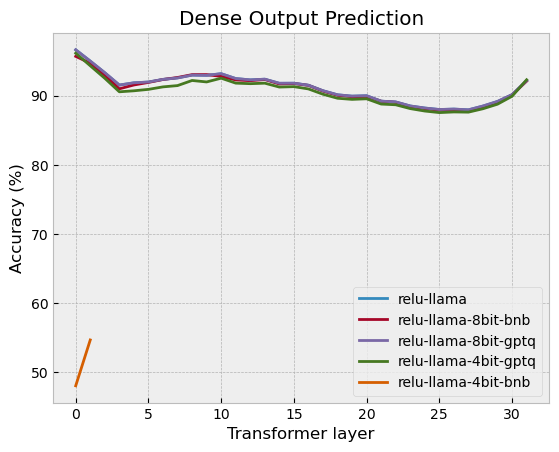

In [114]:
visualize_all(percentage_correct_dense_list, model_names, "Dense Output Prediction", "dense.png")


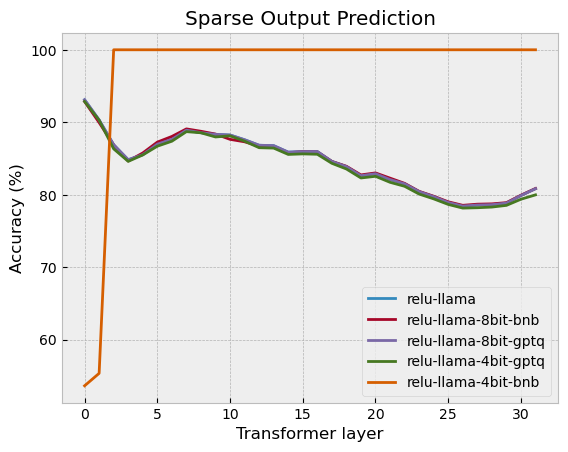

In [115]:
visualize_all(percentage_correct_sparse_list, model_names, "Sparse Output Prediction", "sparse.png")

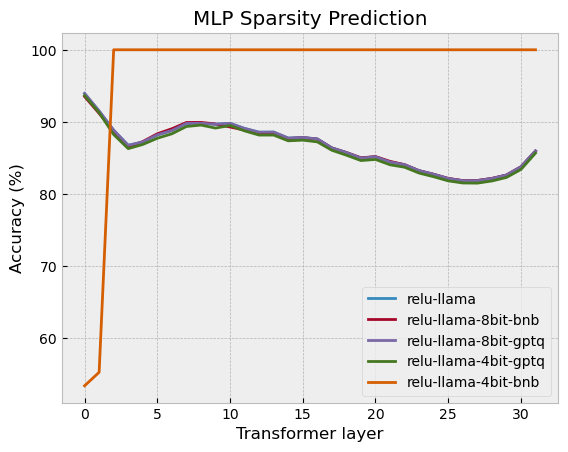

In [116]:
visualize_all(percentage_correct_total_list, model_names, "MLP Sparsity Prediction", "total_mlp_pred_eval.png")


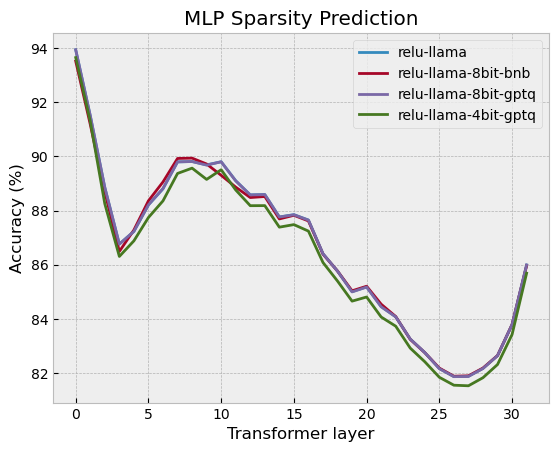

In [127]:
visualize_all(percentage_correct_total_list[:4], model_names[:4], "MLP Sparsity Prediction", "total_mlp_pred_eval_wo_4bnb.png")


In [22]:
model_name "relu-llama"


Evaluating Layer 0 
correctly_predicted count :  5402856
mislabeled count :  0
Evaluating Layer 1 
correctly_predicted count :  5807295
mislabeled count :  0
Evaluating Layer 2 
correctly_predicted count :  6935034
mislabeled count :  0
Evaluating Layer 3 
correctly_predicted count :  6541135
mislabeled count :  0
Evaluating Layer 4 
correctly_predicted count :  6107266
mislabeled count :  0
Evaluating Layer 5 
correctly_predicted count :  5610118
mislabeled count :  0
Evaluating Layer 6 
correctly_predicted count :  5687430
mislabeled count :  0
Evaluating Layer 7 
correctly_predicted count :  5565556
mislabeled count :  0
Evaluating Layer 8 
correctly_predicted count :  6448338
mislabeled count :  0
Evaluating Layer 9 
correctly_predicted count :  6664748
mislabeled count :  0
Evaluating Layer 10 
correctly_predicted count :  7196322
mislabeled count :  0
Evaluating Layer 11 
correctly_predicted count :  7030895
mislabeled count :  0
Evaluating Layer 12 
correctly_predicted count :  

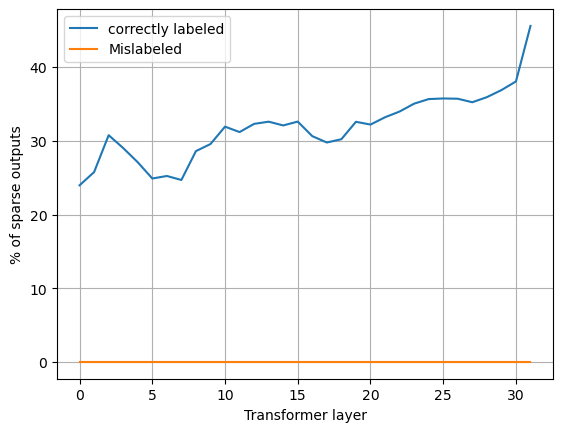

In [75]:
percentage_correct, percentage_missed = evaluate_sparsity_predictors(model_name, D, mlp_inputs, act_outputs)
visualize(percentage_correct, percentage_missed)